# Check how to limit the maximum depth

# Method 1: Using grad from Midas

In [1]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
import torch
from typing import Any, Callable, Dict, List, Optional, Union
from diffusers import StableDiffusionPipeline

class StableDiffusionHackedPipeline(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_noise: Optional[Callable[[int, int, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    if callback_noise is not None:
                        callback_noise(i, t, noise_pred_uncond, noise_pred_text, latent_model_input)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if output_type == "latent":
            image = latents
            has_nsfw_concept = None
        elif output_type == "pil":
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

            # 10. Convert to PIL
            image = self.numpy_to_pil(image)
        else:
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


In [2]:
import torch

pipe = StableDiffusionHackedPipeline.from_pretrained(
    "/home/wukailu/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/39593d5650112b4cc580433f6b0435385882d819",
    torch_dtype=torch.float16).to("cuda")
pipe.enable_xformers_memory_efficient_attention()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/wukailu/miniconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/home/wukailu/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/wukailu/miniconda3/lib

In [36]:
def print_callback(i, t, noise_pred_uncond, noise_pred_text, latent_model_input):
    print(i, t, noise_pred_uncond.shape, noise_pred_text.shape, latent_model_input.shape)

def run(callback):
    generator = torch.Generator().manual_seed(233)
    ret = pipe(prompt="a bedroom", generator=generator, callback_noise=callback, num_inference_steps=300)
    return ret.images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

0 tensor(991, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
1 tensor(981, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
2 tensor(981, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
3 tensor(971, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
4 tensor(961, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
5 tensor(951, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
6 tensor(941, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
7 tensor(931, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 64, 64])
8 tensor(921, device='cuda:0') torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([2, 4, 6

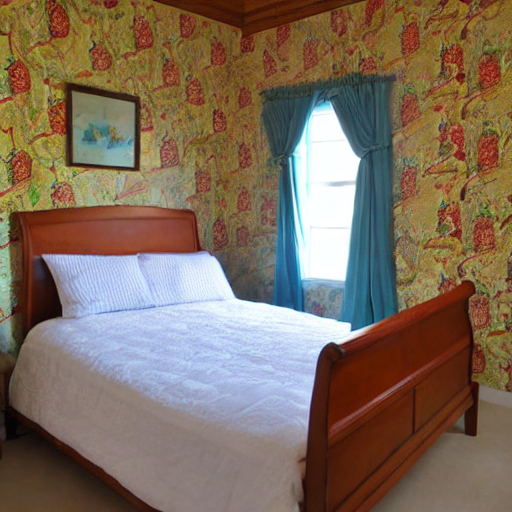

In [58]:
image = run(print_callback)
image

In [4]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")
from annotator.midas import MidasDetector

midas = MidasDetector()

In [5]:
def decode_latents(ltt):
    latent = ltt * (1 / pipe.vae.config.scaling_factor)
    image = pipe.vae.decode(latent, return_dict=False)[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

In [37]:
pipe.safety_checker = None

def midas_callback(i, t, noise_pred_uncond, noise_pred_text, latent_model_input):
    pipe.vae.float()
    with torch.enable_grad():
        ltt: torch.Tensor = latent_model_input[:1].detach().float()
        ltt = ltt.requires_grad_(True)
        image_depth = decode_latents(ltt)
        pred = midas.disp_with_grad(image_depth)
        target = torch.ones_like(pred) * (pred.mean().detach())
        loss_func = torch.nn.MSELoss()  # MSE because we assume it follows a normal distribution
        loss = loss_func(pred.flatten(start_dim=1), target.flatten(start_dim=1))
        loss.backward()
    pipe.vae.half()

    grad = ltt.grad * -0.5 * 100 / (100**2)  # divide sigma^2, if depth distribution follows N(target, sigma)
    grad = grad.half()
    sqrt_one_minus_alpha_prod = (1 - pipe.scheduler.alphas_cumprod[t]) ** 0.5
    noise_pred_uncond -= sqrt_one_minus_alpha_prod.to(grad) * grad
    noise_pred_text -= sqrt_one_minus_alpha_prod.to(grad) * grad

    # delta = noise_pred_text - noise_pred_uncond  # mean 0, std 0.01
    # print("noise_pred_uncond: ", noise_pred_uncond.mean(), noise_pred_uncond.std())
    # print("grad: ", grad.mean(), grad.std())

In [38]:
image = run(midas_callback)

  0%|          | 0/300 [00:00<?, ?it/s]

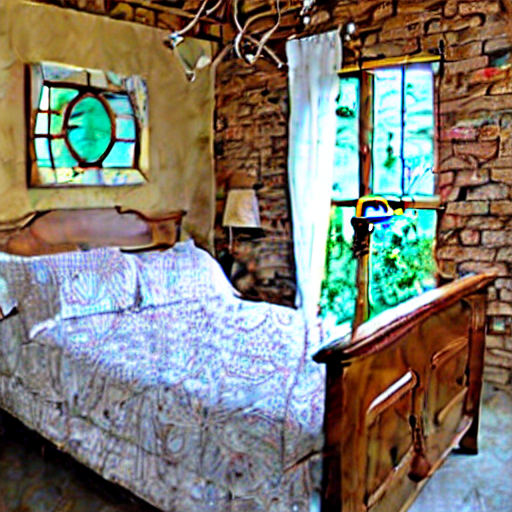

In [30]:
image

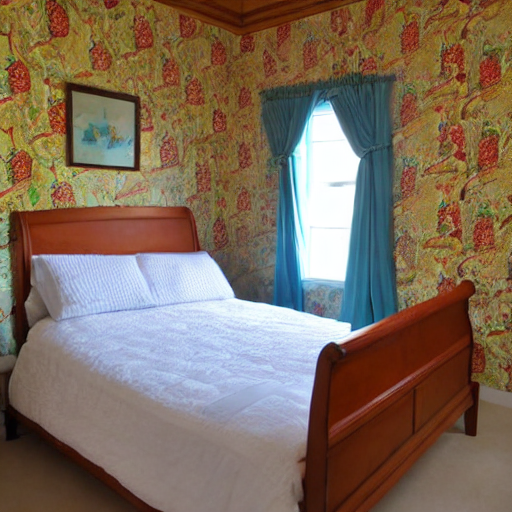

In [88]:
image

In [31]:
def pred_disp(input_image) -> torch.FloatTensor:
    from annotator.util import HWC3
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = midas(input_image)
    return detected_map[0]

In [32]:
import numpy as np
disp = pred_disp(np.array(image))

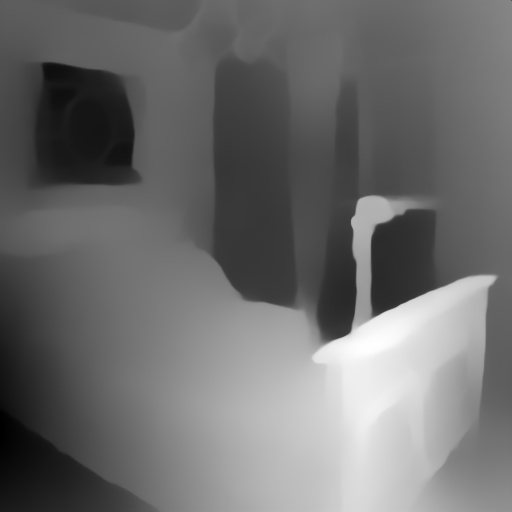

In [33]:
from PIL import Image
Image.fromarray(disp)

In [34]:
from einops import rearrange
with torch.no_grad():
    image_depth = torch.from_numpy(np.array(image)).float().cuda()
    image_depth = image_depth / 127.5 - 1.0  # [-1, 1]
    image_depth = rearrange(image_depth, 'h w c -> 1 c h w')
    ret = midas.disp_with_grad(image_depth)

In [35]:
ret.mean(), ret.std(), ret.max(), ret.min()

(tensor(1318.7871, device='cuda:0'),
 tensor(350.7481, device='cuda:0'),
 tensor(2292.7415, device='cuda:0'),
 tensor(585.9406, device='cuda:0'))

In [110]:
ret.mean(), ret.std(), ret.max(), ret.min()

(tensor(1213.5830, device='cuda:0'),
 tensor(678.4129, device='cuda:0'),
 tensor(2911.6084, device='cuda:0'),
 tensor(225.9081, device='cuda:0'))

# Method 2: using grad from a ReLU network between depth and target

In [3]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")
import torch
from torch import nn
from ldm.modules.diffusionmodules.openaimodel import UNetModel

device = torch.device("cpu")
mean_std = torch.tensor([
    (-0.24595006, 0.54566), # R
    (-0.13202806, 0.55846), # G
    (-0.02775778, 0.57430), # B
    ( 1.72314970, 0.99023), # D
])
mean, std = mean_std.to(device=device).unbind(dim=1)

In [4]:
IMG_SIZE = 128
def get_unet():
    unet = UNetModel(image_size=IMG_SIZE,
                     in_channels=8, out_channels=4,
                     model_channels=128, # the base channel (smallest)
                     channel_mult=[1, 2, 3, 3, 4, 4],
                     num_res_blocks=2,
                     num_head_channels=32,
                     # down 1     2      4          8          16         32
                     # res  128   64     32         16         8          4
                     # chan 128   256    384        384        512        512
                     # type conv  conv   conv+attn  conv+attn  conv+attn  conv+attn
                     attention_resolutions=[4, 8, 16, 32],
                     use_checkpoint=True,
                     use_fp16=False,
                    )
    # use num_groups==1, to avoid color shift problem
    for name, module in unet.named_modules():
        if isinstance(module, nn.GroupNorm):
            module.num_groups = 1
            print(f"convert GN to LN for module: {name}")
    return unet

class Model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.unet = get_unet()
        # dummy params
        self.no_pixel = nn.Parameter(torch.zeros(4))

    def forward(self, rgbd, t):
        """
        Args:
            rgbd.shape == (B, 4, H, W)

            NOTE
            curr view (i.e. rgbd) is noised
        """
        rgbd_render = torch.zeros_like(rgbd)
        unet_in = torch.cat([rgbd_render, rgbd], dim=1) # (B, 4 + 4, H, W)
        pred = self.unet(unet_in, t) # (B, C, H, W)
        return pred

In [5]:
# load model from dir_ckpt, "checkpoint", "model.pt"
model_path = "/home/wukailu/RGBD-Diffusion/out/RGBD2/checkpoint/model.pt"
ckpt = torch.load(model_path)
model = Model()
model.load_state_dict(ckpt['model'])

convert GN to LN for module: input_blocks.1.0.in_layers.0
convert GN to LN for module: input_blocks.1.0.out_layers.0
convert GN to LN for module: input_blocks.2.0.in_layers.0
convert GN to LN for module: input_blocks.2.0.out_layers.0
convert GN to LN for module: input_blocks.4.0.in_layers.0
convert GN to LN for module: input_blocks.4.0.out_layers.0
convert GN to LN for module: input_blocks.5.0.in_layers.0
convert GN to LN for module: input_blocks.5.0.out_layers.0
convert GN to LN for module: input_blocks.7.0.in_layers.0
convert GN to LN for module: input_blocks.7.0.out_layers.0
convert GN to LN for module: input_blocks.7.1.norm
convert GN to LN for module: input_blocks.8.0.in_layers.0
convert GN to LN for module: input_blocks.8.0.out_layers.0
convert GN to LN for module: input_blocks.8.1.norm
convert GN to LN for module: input_blocks.10.0.in_layers.0
convert GN to LN for module: input_blocks.10.0.out_layers.0
convert GN to LN for module: input_blocks.10.1.norm
convert GN to LN for modu

<All keys matched successfully>

In [22]:
from einops import rearrange
from diffusers import DDIMScheduler
from tqdm import tqdm

num_steps  = 50
diffusion_scheduler = DDIMScheduler(num_train_timesteps=1000, clip_sample=False, set_alpha_to_one=False)
@torch.no_grad()
def sampling_forward_fn(rgbd, t): # forward func only for classifier-free sampling
    t = t.reshape([1])
    # forward
    with torch.cuda.amp.autocast(enabled=True):
        pred = model.unet(rgbd, t)
    return pred.float()

class Sampler:
    @torch.no_grad()
    def __call__(self, seed, call_back=None):
        # sample noise
        kwargs_rand = lambda seed, device=device: dict(generator=torch.Generator(device).manual_seed(seed), device=device)
        z_t = torch.randn([1, 4, IMG_SIZE, IMG_SIZE], **kwargs_rand(seed))
        # compute the known part by rendering the mesh onto the current view
        known_part = torch.zeros((1, 4, IMG_SIZE, IMG_SIZE), device=device)
        #
        diffusion_scheduler.set_timesteps(num_steps)
        #
        time_step_lst = diffusion_scheduler.timesteps
        assert num_steps == diffusion_scheduler.num_inference_steps == len(time_step_lst)
        #
        model.eval()
        for i, t in tqdm(enumerate(time_step_lst)):
            rgbd_in = torch.cat([known_part, z_t], dim=1)  # (1, 8, H, W)
            pred_noise = sampling_forward_fn(rgbd_in, t.to(device=device))
            if call_back is not None:
                call_back(i, t, pred_noise, rgbd_in)
            z_t = diffusion_scheduler.step(pred_noise, t.to(device=device), z_t).prev_sample
        # reshape to (H, W, C)
        rgbd_curr = rearrange(z_t, "() C H W -> H W C")
        rgbd_curr = rgbd_curr * std + mean
        rgbd_curr[..., :3] = (rgbd_curr[..., :3] + 1) / 2 # 0~1
        rgbd_curr[..., :3] = rgbd_curr[..., :3].clamp(min=0, max=1)
        rgbd_curr[...,  3] = rgbd_curr[...,  3].clamp(min=0)
        return rgbd_curr

def midas_callback_rgbd(i, t, noise_pred_uncond, model_input):
    # TODO: check this
    with torch.cuda.amp.autocast(enabled=True):
        with torch.enable_grad():
            ltt: torch.Tensor = model_input.detach()
            ltt = ltt.requires_grad_(True)

            pred = ltt[:, -1]
            target = torch.ones_like(pred) * (pred.mean().detach())
            loss_func = torch.nn.MSELoss()  # MSE because we assume it follows a normal distribution
            loss = loss_func(pred.flatten(start_dim=1), target.flatten(start_dim=1))
            loss.backward()

        grad = ltt.grad * -0.5 * 3 / (1**2)  # divide sigma^2, if depth distribution follows N(target, sigma)
        grad = grad.to(dtype=noise_pred_uncond.dtype)
        sqrt_one_minus_alpha_prod = (1 - diffusion_scheduler.alphas_cumprod[t]) ** 0.5
        noise_pred_uncond -= sqrt_one_minus_alpha_prod.to(grad) * grad
        print("grad", grad.mean(), grad.std(), grad.shape)
        print("noise_pred_uncond", noise_pred_uncond.mean(), noise_pred_uncond.std(), noise_pred_uncond.shape)

In [32]:
rgbd = Sampler()(seed=235) # (H, W, 4)

50it [00:27,  1.84it/s]


In [33]:
from PIL import Image
import numpy as np

def show_rgbd(rgbd_display):
    rgbd_input = rgbd_display.clone()
    rgbd_input[..., :3] = rgbd_input[..., :3] * 255
    d_max = rgbd_input[..., 3:].max()
    rgbd_input[..., 3:] = (rgbd_input[..., 3:] / d_max) * 255
    pil = Image.fromarray(rgbd_input.numpy().round().astype(np.uint8)[..., :3])
    display(pil)
    pil = Image.fromarray(rgbd_input.numpy().round().astype(np.uint8)[..., 3])
    display(pil)
    pil = Image.fromarray(rgbd_input.numpy().round().astype(np.uint8))
    display(pil)

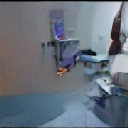

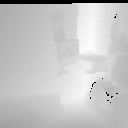

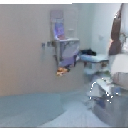

In [34]:
show_rgbd(rgbd)

# Method 3: extend method 2 to latent diffusion